In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from core.data.utils import read_all_datasets, read_all_metadata
from core.data.processing.normalization import robust_zscore_normalization_per_dataset

In [3]:
DATA_DIR = '../../db'

dataset, dataset_label = read_all_datasets(DATA_DIR, dropna=False)
metadata = read_all_metadata(DATA_DIR)

In [4]:
y = metadata[metadata.disease.isin(['Ctrl', 'UC']) & metadata.time_of_biopsy.isin([None, 'W0', 'Before'])].disease
dataset_labels = dataset_label.loc[y.index]
X = dataset.loc[y.index]
X = X.dropna(axis=1)

X.shape, y.shape

((934, 14279), (934,))

In [5]:
X_norm = robust_zscore_normalization_per_dataset(X, dataset_label)

In [6]:
from core.utils.genes import entrez_id_to_gene_symbol

X_norm = entrez_id_to_gene_symbol(X_norm)

20 input query terms found no hit:	['10638', '129790', '157247', '158295', '158696', '23285', '26148', '283174', '283588', '284083', '2


In [7]:
from core.stats.tests import test_two_groups


test_data = X_norm.astype(float)
test_data['disease'] = y

test_results = test_two_groups(test_data, 'disease', alpha=0.05/test_data.shape[1])

Test results for disease:
Group counts: 235 | 699
- BACE2: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.9087
- CCL11: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.7703
- GPX8: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.8996
- DAPP1: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.8065
- SAMD9L: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.7356
- PDZK1IP1: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.8228
- IL1B: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.8137
- COL1A2: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.7676
- SLC39A5: [Mann-Whitney U test] p-value = 0.0; mean difference = -0.7068
- C4BPB: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.7185
- DUOX2: [Mann-Whitney U test] p-value = 0.0; mean difference = 1.1104
- UBE2L6: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.8407
- TGFBI: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.784
- CENPV: [Mann-Whitne

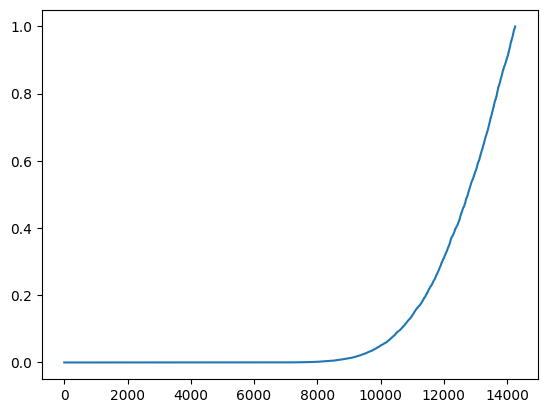

In [8]:
import matplotlib.pyplot as plt

plt.plot([p for f, (p, d, t) in test_results]);

In [9]:
genes = [f for f, (p, d, t) in test_results]

In [11]:
import gseapy as gp

# Define your gene list
gene_list = genes  # use your gene list variable

# Define parameters for Enrichr
enrichr_libraries = ['KEGG_2021_Human']  # You can add more libraries as needed

# Perform Enrichment Analysis
enrichr_results = gp.enrichr(gene_list=gene_list, gene_sets=enrichr_libraries, organism='Human', outdir='../../results/enrichr_kegg', cutoff=0.05)

# Viewing the results
print(enrichr_results.results.head())

/usr/local/anaconda3/envs/ibd/lib/python3.11/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(


          Gene_set                               Term  Overlap       P-value  \
0  KEGG_2021_Human               Salmonella infection  225/249  1.436818e-13   
1  KEGG_2021_Human                 Pathways in cancer  444/531  1.471533e-11   
2  KEGG_2021_Human     Human papillomavirus infection  284/331  2.636225e-10   
3  KEGG_2021_Human                        Endocytosis  219/252  2.523892e-09   
4  KEGG_2021_Human  Thyroid hormone signaling pathway  112/121  5.952414e-09   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      4.597816e-11            0                     0    3.819073   
1      2.354452e-09            0                     0    2.088664   
2      2.811973e-08            0                     0    2.461989   
3      2.019113e-07            0                     0    2.698032   
4      3.809545e-07            0                     0    5.042168   

   Combined Score                                              Genes  
0      112.934488  CYFIP2;C